In [1]:
import os
from pynq import Overlay
from pynq import MMIO
import xrfclk
import xrfdc
import struct
from time import sleep
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal

In [3]:
# FIRMWARE UPLOAD
firmware = Overlay("single_chan_4eth_v8p2.bit",ignore_version=True)

# INITIALIZING PLLs
clksrc = 409.6 # MHz
xrfclk.set_all_ref_clks(clksrc)

In [4]:
lofreq = 1000.000 # [MHz]
rf_data_conv = firmware.usp_rf_data_converter_0
rf_data_conv.adc_tiles[0].blocks[0].MixerSettings['Freq']=lofreq
rf_data_conv.dac_tiles[1].blocks[3].MixerSettings['Freq']=lofreq
rf_data_conv.adc_tiles[0].blocks[0].UpdateEvent(xrfdc.EVENT_MIXER)
rf_data_conv.dac_tiles[1].blocks[3].UpdateEvent(xrfdc.EVENT_MIXER)

In [5]:
# SET ETHERNET IPS and MACS
eth_regs_port3 = firmware.eth_wrap.eth_regs_port3 # 0x00 & 0x04 & 0x08 - src and dst macs, 0x0c - src ip, 0x0f - dst ip
eth_regs_port2 = firmware.eth_wrap.eth_regs_port2
eth_regs_port1 = firmware.eth_wrap.eth_regs_port1
eth_regs_port0 = firmware.eth_wrap.eth_regs_port0
#ips and macs
chan3_src_ip_int32 = int("c0a80335",16)
chan3_dst_ip_int32 = int("c0a80328",16)
chan3_src_mac0_int32 = int("deadbeef",16)
chan3_src_mac1_int16 = int("feed",16)
chan3_dst_mac0_int16 = int("2bb0",16) #  startech dongle 80:3f:5d:09:6b:1d
chan3_dst_mac1_int32 = int("803f5d09",16)

chan2_src_ip_int32 = int("c0a80334",16)
chan2_dst_ip_int32 = int("c0a80328",16)
chan2_src_mac0_int32 = int("deadbeef",16)
chan2_src_mac1_int16 = int("feed",16)
chan2_dst_mac0_int16 = int("2bb0",16) #  startech dongle 80:3f:5d:09:6b:1d
chan2_dst_mac1_int32 = int("803f5d09",16)

chan1_src_ip_int32 = int("c0a80333",16)
chan1_dst_ip_int32 = int("c0a80328",16)
chan1_src_mac0_int32 = int("deadbeef",16)
chan1_src_mac1_int16 = int("feed",16)
chan1_dst_mac0_int16 = int("2bb0",16) #  startech dongle 80:3f:5d:09:6b:1d
chan1_dst_mac1_int32 = int("803f5d09",16)

chan0_src_ip_int32 = int("c0a80332",16)
chan0_dst_ip_int32 = int("c0a80328",16)
chan0_src_mac0_int32 = int("deadbeef",16)
chan0_src_mac1_int16 = int("feed",16)
chan0_dst_mac0_int16 = int("2bb0",16) #  startech dongle 80:3f:5d:09:6b:1d
chan0_dst_mac1_int32 = int("803f5d09",16)
# write values
eth_regs_port3.write( 0x00, chan3_src_mac0_int32) 
eth_regs_port3.write( 0x04, (chan3_dst_mac0_int16<<16) + chan3_src_mac1_int16)
eth_regs_port3.write( 0x08, chan3_dst_mac1_int32)
eth_regs_port3.write( 0x0c, chan3_src_ip_int32)
eth_regs_port3.write( 0x10, chan3_dst_ip_int32)

eth_regs_port2.write( 0x00, chan2_src_mac0_int32) 
eth_regs_port2.write( 0x04, (chan2_dst_mac0_int16<<16) + chan2_src_mac1_int16)
eth_regs_port2.write( 0x08, chan2_dst_mac1_int32)
eth_regs_port2.write( 0x0c, chan2_src_ip_int32)
eth_regs_port2.write( 0x10, chan2_dst_ip_int32)

eth_regs_port1.write( 0x00, chan1_src_mac0_int32) 
eth_regs_port1.write( 0x04, (chan1_dst_mac0_int16<<16) + chan1_src_mac1_int16)
eth_regs_port1.write( 0x08, chan1_dst_mac1_int32)
eth_regs_port1.write( 0x0c, chan1_src_ip_int32)
eth_regs_port1.write( 0x10, chan1_dst_ip_int32)

eth_regs_port0.write( 0x00, chan0_src_mac0_int32) 
eth_regs_port0.write( 0x04, (chan0_dst_mac0_int16<<16) + chan0_src_mac1_int16)
eth_regs_port0.write( 0x08, chan0_dst_mac1_int32)
eth_regs_port0.write( 0x0c, chan0_src_ip_int32)
eth_regs_port0.write( 0x10, chan0_dst_ip_int32)

In [6]:
eth_delay_reg = firmware.eth_wrap.eth_delay # programmable delay for eth byte shift
data_in_mux = firmware.eth_wrap.data_in_mux
###############################
# Ethernet Delay Lines  
###############################
eth_delay_reg.write(0x00, -22 + (4<<16))#-22 + (4<<16)) #-22 + (4<<16))#44 + (4<<16)) # data output from eth buffer delay/ input to eth buffer delay <<16 delay
eth_delay_reg.write(0x08, 0) # ethernet start pulse out delay
###############################
# Data MUX
###############################
data_in_mux.write( 0x00, 1) # coffee when 0, data when 1
data_in_mux.write( 0x08, (509) + ((8189)<<16) ) # ethernet max write count and max read count

# Generating DDS/DAC Waveform

In [7]:
def phase_shift(ts, phase):
    y = ts*np.exp(1j*phase)
    return ts.real + 1j*y.imag

def norm_wave(ts, max_amp=2**15-1):
    """
     Re-configure generated data values to fit LUT
    """
    Imax = max(abs(ts.real))
    Qmax = max(abs(ts.imag))
    norm = max(abs(ts))
    dacI = ((ts.real/norm)*max_amp).astype("int16")
    dacQ = ((ts.imag/norm)*max_amp).astype("int16")
    return dacI, dacQ

def genWaveform(freq_list, vna = False, verbose=False):
    """
    Takes a list of specified frequencies and generates....stuff and things, then 
    uploads to the bram.
    
    params
        freq_list: np.array
            list of tones to generate [Hz]
        verbose: bool
            enable / disable printing (and or) plotting of data
    """
    #####################################################
    # HARDCODED LUT PARAMS
    #####################################################
    addr_size=18   # address bit width
    channels= 2    # data points per memory address for DAC
    fs = 1024e6    # sampling rate of D/A, FPGA fabric = fs/2
    C=2            # decimation factor
    data_p = channels*2**(addr_size) # length of timestream or length of LUT+1
    
    #####################################################
    #  SET FREQ for LUT
    #####################################################
    if vna:
      N = 1000 # number of tones to make
      #freqs = -1*C*np.linspace(-250.0e6, 250.0e6,N) # equally spaced tones
      freqs_up = 1*C*np.linspace(-251e6,-1e6, N//2)
      freqs_lw = 1*C*np.linspace(2.15e6,252.15e6,N//2)
      freqs = np.append(freqs_up,freqs_lw)
      #freqs = freqs_up
    else:
      freqs = C*freq_list # equally spaced tones
    phases = np.random.uniform(-np.pi,np.pi,len(freqs))

    ######################################################
    # DAC Params
    ######################################################
    A = 2**15-1 # 16 bit D/A, expecting signed values.
    freq_res = fs/data_p # Hz
    fftbin_bw = 500e3 # Hz for effective bandwidth of 512MHz/1024 point fft on adc
    print(freq_res)
    
    ######################################################
    # GENERATE LUT WAVEFORM FROM FREQ LIST
    ######################################################
    freqs = np.round(freqs/(freq_res))*freq_res
    print("{} Frequencies Generated:".format(len(freqs)))
    print(freqs/C*1e-6)
    delta = np.zeros(data_p,dtype="complex") # empty array of deltas
    fft_bin_nums=np.zeros(len(freqs),dtype=int) # array of all dac bin index
    for i in range(len(freqs)):
        bin_num = np.round((freqs[i]/freq_res)).astype('int')
        fft_bin_nums[i]=(np.round((freqs[i]/fftbin_bw/C)).astype('int'))*C
        delta[bin_num] = np.exp(1j*phases[i]) 
    ts = np.fft.ifft(delta)

    # GENERATE DDC WAVEFORM FROM BEAT FREQS
    f_fft_bin = fft_bin_nums*fftbin_bw
    f_beat = (freqs/C - f_fft_bin/C)
    
    if verbose:
        print("\nBeat Frequencies:")
        print(f_beat)
        print(freqs/C)

    ###########
    # new DDC
    ###########
    wave_ddc = np.zeros( int(data_p), dtype="complex") # empty array of deltas
    delta_ddc = np.zeros( shape=(len(freqs),2**9), dtype="complex") # empty array of deltas
    beat_ddc = np.zeros(shape=(len(freqs),2**9), dtype="complex")
    bin_num_ddc = np.round(f_beat*2/freq_res) # factor of 2 for half a bin width
    
    print("bin num ddc "+str(bin_num_ddc))

    for i in range(len(freqs)): 
        delta_ddc[i,int(bin_num_ddc[i])] = np.exp(-1j*phases[i])
        beat_ddc[i] = np.conj(np.fft.ifft(delta_ddc[i]))
        
    for i in range(1024):
        if (i<len(freqs)):
            wave_ddc[i::1024] = beat_ddc[i]
        else:
            wave_ddc[i::1024] = 0
    
    dacI, dacQ = norm_wave(ts)
    ddcI, ddcQ = norm_wave(wave_ddc, max_amp=(2**13)-1)
    return dacI, dacQ, ddcI, ddcQ, freqs

def load_DAC(wave_real, wave_imag):
    base_addr_DAC_I = 0x0400000000
    base_addr_DAC_Q = 0x0400100000
    mem_size = 262144*4 # 32 bit address slots
    mmio_bramI = MMIO(base_addr_DAC_I,mem_size)
    mmio_bramQ = MMIO(base_addr_DAC_Q,mem_size)
    I0, I1 = wave_real[0::2], wave_real[1::2]
    Q0, Q1 = wave_imag[0::2], wave_imag[1::2]
    dataI = ((np.int32(Q1) << 16) + I1).astype("int32")
    dataQ = ((np.int32(Q0) << 16) + I0).astype("int32")
    mmio_bramI.array[0:262144] = dataI[0:262144]
    mmio_bramQ.array[0:262144] = dataQ[0:262144]
    print("DAC waveform uploaded to AXI BRAM")
    return

def load_DDS(wave_real, wave_imag):
    
    base_addr_DDS_I = 0x0080000000
    base_addr_DDS_Q = 0x0080100000
    mem_size = 262144*4 # 32 bit address slots
    mmio_bramI = MMIO(base_addr_DDS_I,mem_size)
    mmio_bramQ = MMIO(base_addr_DDS_Q,mem_size)
    I0, I1 = wave_real[0::2], wave_real[1::2]
    Q0, Q1 = wave_imag[0::2], wave_imag[1::2]
    dataI = ((np.int32(I1) << 16) + I0).astype("int32")
    dataQ = ((np.int32(Q1) << 16) + Q0).astype("int32")
    mmio_bramI.array[0:262144] = dataI[0:262144]
    mmio_bramQ.array[0:262144] = dataQ[0:262144]
    print("DDC waveform uploaded to AXI BRAM")
    return

def load_bin_list(freqs):
    bin_list = np.int64( np.round(freqs/1e6) )
    print("bin_list:"+str(bin_list))
    # DSP REGS
    dsp_regs = firmware.dsp_regs_0
    # 0x00 -  fft_shift[9 downto 0], load_bins[22 downto 12], lut_counter_rst[11 downto 11] 
    # 0x04 -  bin_num[9 downto 0]
    # 0x08 -  accum_len[23 downto 0], accum_rst[24 downto 24], sync_in[26 downto 26] (start dac)
    # 0x0c -  dds_shift[8 downto 0]
    
    # initialization 
    sync_in = 2**26
    accum_rst = 2**24  # (active low)
    accum_length = (2**19)-1
    ################################################
    # Load DDC bins
    ################################################
    offs=0
    
    # only write tones to bin list
    for addr in range(1024):
        if addr<(len(bin_list)):
            print("addr = {}, bin# = {}".format(addr, bin_list[addr]))
            dsp_regs.write(0x04,int(bin_list[addr]))
            dsp_regs.write(0x00, ((addr<<1)+1)<<12)
            dsp_regs.write(0x00, 0)
        else:
            dsp_regs.write(0x04,0)
            dsp_regs.write(0x00, ((addr<<1)+1)<<12)
            dsp_regs.write(0x00, 0)
    return

def load_waveform_into_mem(freqs, dac_r,dac_i,dds_r,dds_i):
    #######################################################
    # Load configured LUT values into FPGA memory
    #######################################################
    
    # Arming DDC Waveform
    ########################
    dsp_regs = firmware.dsp_regs_0
    # 0x00 -  fft_shift[9 downto 0], load_bins[22 downto 12], lut_counter_rst[11 downto 11] 
    # 0x04 -  bin_num[9 downto 0]
    # 0x08 -  accum_len[23 downto 0], accum_rst[24 downto 24], sync_in[26 downto 26] (start dac)
    # 0x0c -  dds_shift[8 downto 0]
    # initialization  
    sync_in = 2**26
    accum_rst = 2**24  # (active rising edge)
    accum_length = (2**19)-1 # (2**18)-1
    
    fft_shift=0
    if len(freqs)<400:
        fft_shift = 2**9-1
    else:
        fft_shift = 2**2-1
    
    # WRITING TO DDS SHIFT
    dsp_regs.write(0x0c,262)
    dsp_regs.write(0x08,accum_length)
    
    # reset DAC/DDS counter
    dsp_regs.write(0x00, 2**11) # reset dac/dds counter
    dsp_regs.write(0x00, 0) # reset dac/dds counter
    dsp_regs.write(0x08,accum_length | accum_rst)
    
    load_DAC(dac_r,dac_i)
    load_DDS(dds_r,dds_i)
    sleep(.5)
    dsp_regs.write(0x00, fft_shift) # set fft shift
    ########################
    dsp_regs.write(0x08, accum_length | sync_in)
    sleep(0.5)
    dsp_regs.write(0x08, accum_length | accum_rst | sync_in)
    return 0

def get_snap_data(mux_sel):
    # WIDE BRAM
    axi_wide = firmware.axi_wide_ctrl# 0x0 max count, 0x8 capture rising edge trigger
    max_count = 32768
    #mux_sel = 3
    axi_wide.write(0x08, mux_sel<<1) # mux select 0-adc, 1-pfb, 2-ddc, 3-accum
    axi_wide.write(0x00, max_count - 16) # -4 to account for extra delay in write counter state machine
    axi_wide.write(0x08, mux_sel<<1 | 0)
    axi_wide.write(0x08, mux_sel<<1 | 1)
    axi_wide.write(0x08, mux_sel<<1 | 0)
    base_addr_wide = 0x00_A007_0000
    mmio_wide_bram = MMIO(base_addr_wide,max_count)
    wide_data = mmio_wide_bram.array[0:8192]# max/4, bram depth*word_bits/32bits
    if mux_sel==0:
        #adc parsing
        up0, lw0 = np.int16(wide_data[0::4] >> 16), np.int16(wide_data[0::4] & 0x0000ffff)
        up1, lw1 = np.int16(wide_data[1::4] >> 16), np.int16(wide_data[1::4] & 0x0000ffff)
        I = np.zeros(4096)
        Q = np.zeros(4096)
        Q[0::2] = lw0
        Q[1::2] = up0
        I[0::2] = lw1
        I[1::2] = up1
    elif mux_sel==1:
        # pfb
        chunk0 = (np.uint64(wide_data[1::4]) << np.uint64(32)) + np.uint64(wide_data[0::4])
        chunk1 = (np.uint64(wide_data[2::4]) << np.uint64(32)) + np.uint64(wide_data[1::4])
        q0 = np.int64((chunk0 & 0x000000000003ffff)<<np.uint64(46))/2**32
        i0 = np.int64(((chunk0>>18) & 0x000000000003ffff)<<np.uint64(46))/2**32
        q1 = np.int64(((chunk1>>4)  & 0x000000000003ffff)<<np.uint64(46))/2**32
        i1 = np.int64(((chunk1>>22)  & 0x000000000003ffff)<<np.uint64(46))/2**32
        I = np.zeros(4096)
        Q = np.zeros(4096)
        Q[0::2] = q0
        Q[1::2] = q1
        I[0::2] = i0
        I[1::2] = i1
    elif mux_sel==2:
        # ddc
        chunk0 = (np.uint64(wide_data[1::4]) << np.uint64(32)) + np.uint64(wide_data[0::4])
        chunk1 = (np.uint64(wide_data[2::4]) << np.uint64(32)) + np.uint64(wide_data[1::4])
        q0 = np.int64((chunk0 & 0x00000000000fffff)<<np.uint64(45))/2**32
        i0 = np.int64(((chunk0>>19) & 0x00000000000fffff)<<np.uint64(45))/2**32
        q1 = np.int64(((chunk1>>6)  & 0x00000000000fffff)<<np.uint64(45))/2**32
        i1 = np.int64(((chunk1>>25)  & 0x00000000000fffff)<<np.uint64(45))/2**32
        I = np.zeros(4096)
        Q = np.zeros(4096)
        Q[0::2] = q0
        Q[1::2] = q1
        I[0::2] = i0
        I[1::2] = i1
    elif mux_sel==3:
        # accum
        q0 = (np.int32(wide_data[1::4])).astype("float")
        i0 = (np.int32(wide_data[0::4])).astype("float")
        q1 = (np.int32(wide_data[3::4])).astype("float")
        i1 = (np.int32(wide_data[2::4])).astype("float")
        I = np.zeros(4096)
        Q = np.zeros(4096)
        Q[0::2] = q0
        Q[1::2] = q1
        I[0::2] = i0
        I[1::2] = i1    
    return I, Q

In [8]:
LUT_I, LUT_Q, DDS_I, DDS_Q, freqs = genWaveform(np.linspace(20.2e6,50.0e6,1), vna=True, verbose=True)
load_bin_list(freqs)
load_waveform_into_mem(freqs, LUT_I, LUT_Q, DDS_I, DDS_Q)

1953.125
1000 Frequencies Generated:
[-251.         -250.49902344 -249.99804688 -249.49707031 -248.99609375
 -248.49511719 -247.99414062 -247.49316406 -246.9921875  -246.49121094
 -245.99023438 -245.48925781 -244.98828125 -244.48730469 -243.98632812
 -243.48535156 -242.984375   -242.48339844 -241.98242188 -241.48144531
 -240.97949219 -240.47851562 -239.97753906 -239.4765625  -238.97558594
 -238.47460938 -237.97363281 -237.47265625 -236.97167969 -236.47070312
 -235.96972656 -235.46875    -234.96777344 -234.46679688 -233.96582031
 -233.46484375 -232.96386719 -232.46289062 -231.96191406 -231.4609375
 -230.95996094 -230.45898438 -229.95800781 -229.45703125 -228.95605469
 -228.45507812 -227.95410156 -227.453125   -226.95214844 -226.45117188
 -225.95019531 -225.44921875 -224.94824219 -224.44726562 -223.94628906
 -223.4453125  -222.94433594 -222.44335938 -221.94140625 -221.44042969
 -220.93945312 -220.43847656 -219.9375     -219.43652344 -218.93554688
 -218.43457031 -217.93359375 -217.4326171


Beat Frequencies:
[      0.         976.5625    1953.125     2929.6875    3906.25
    4882.8125    5859.375     6835.9375    7812.5       8789.0625
    9765.625    10742.1875   11718.75     12695.3125   13671.875
   14648.4375   15625.       16601.5625   17578.125    18554.6875
   20507.8125   21484.375    22460.9375   23437.5      24414.0625
   25390.625    26367.1875   27343.75     28320.3125   29296.875
   30273.4375   31250.       32226.5625   33203.125    34179.6875
   35156.25     36132.8125   37109.375    38085.9375   39062.5
   40039.0625   41015.625    41992.1875   42968.75     43945.3125
   44921.875    45898.4375   46875.       47851.5625   48828.125
   49804.6875   50781.25     51757.8125   52734.375    53710.9375
   54687.5      55664.0625   56640.625    58593.75     59570.3125
   60546.875    61523.4375   62500.       63476.5625   64453.125
   65429.6875   66406.25     67382.8125   68359.375    69335.9375
   70312.5      71289.0625   72265.625    73242.1875   74218.75
  

bin num ddc [   0.    1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.
   12.   13.   14.   15.   16.   17.   18.   19.   21.   22.   23.   24.
   25.   26.   27.   28.   29.   30.   31.   32.   33.   34.   35.   36.
   37.   38.   39.   40.   41.   42.   43.   44.   45.   46.   47.   48.
   49.   50.   51.   52.   53.   54.   55.   56.   57.   58.   60.   61.
   62.   63.   64.   65.   66.   67.   68.   69.   70.   71.   72.   73.
   74.   75.   76.   77.   78.   79.   80.   81.   82.   83.   84.   85.
   86.   87.   88.   89.   90.   91.   92.   93.   94.   95.   96.   97.
   99.  100.  101.  102.  103.  104.  105.  106.  107.  108.  109.  110.
  111.  112.  113.  114.  115.  116.  117.  118.  119.  120.  121.  122.
  123.  124.  125.  126.  127.  128.  129.  130.  131.  132.  133.  134.
  135.  136.  137.  139.  140.  141.  142.  143.  144.  145.  146.  147.
  148.  149.  150.  151.  152.  153.  154.  155.  156.  157.  158.  159.
  160.  161.  162.  163.  164.  165.  1

addr = 932, bin# = 437
addr = 933, bin# = 438
addr = 934, bin# = 439
addr = 935, bin# = 440
addr = 936, bin# = 441
addr = 937, bin# = 442
addr = 938, bin# = 443
addr = 939, bin# = 444
addr = 940, bin# = 445
addr = 941, bin# = 446
addr = 942, bin# = 447
addr = 943, bin# = 448
addr = 944, bin# = 449
addr = 945, bin# = 450
addr = 946, bin# = 451
addr = 947, bin# = 452
addr = 948, bin# = 453
addr = 949, bin# = 454
addr = 950, bin# = 455
addr = 951, bin# = 456
addr = 952, bin# = 457
addr = 953, bin# = 458
addr = 954, bin# = 459
addr = 955, bin# = 460
addr = 956, bin# = 461
addr = 957, bin# = 462
addr = 958, bin# = 463
addr = 959, bin# = 464
addr = 960, bin# = 465
addr = 961, bin# = 466
addr = 962, bin# = 467
addr = 963, bin# = 468
addr = 964, bin# = 469
addr = 965, bin# = 470
addr = 966, bin# = 471
addr = 967, bin# = 472
addr = 968, bin# = 473
addr = 969, bin# = 474
addr = 970, bin# = 475
addr = 971, bin# = 476
addr = 972, bin# = 477
addr = 973, bin# = 478
addr = 974, bin# = 479
addr = 975,

0

In [11]:
# WIDE BRAM

axi_wide = firmware.axi_wide_ctrl# 0x0 max count, 0x8 capture rising edge trigger
max_count = 32768
mux_sel = 3
axi_wide.write(0x08, mux_sel<<1) # mux select 0-adc, 1-pfb, 2-ddc, 3-accum
axi_wide.write(0x00, max_count - 16) # -4 to account for extra delay in write counter state machine
axi_wide.write(0x08, mux_sel<<1 | 0)
axi_wide.write(0x08, mux_sel<<1 | 1)
axi_wide.write(0x08, mux_sel<<1 | 0)
base_addr_wide = 0x00_A007_0000
mmio_wide_bram = MMIO(base_addr_wide,max_count)
wide_data = mmio_wide_bram.array[0:8192]# max/4, bram depth*word_bits/32bits
print(wide_data[0:32])

[4294966305       4392 4294966408       2763 4294258711     590299
 4294434741     801183     441574 4294067044 4294478734 4294046315
     238597 4293910656 4293855108 4294818563    1116089 4294651356
 4294395867 4293913166     563111 4293866690     379851    1214186
 4294778889 4293670901 4293679441     388337 4293591594 4294849458
    1394919 4294735148]


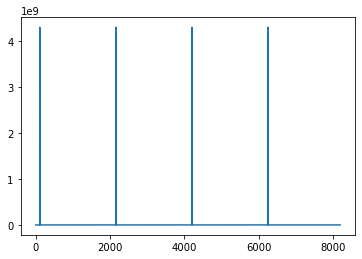

In [132]:
plt.plot(wide_data)

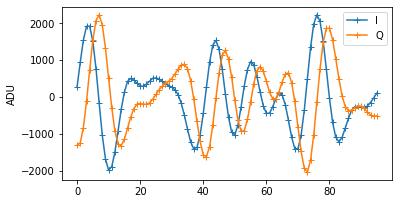

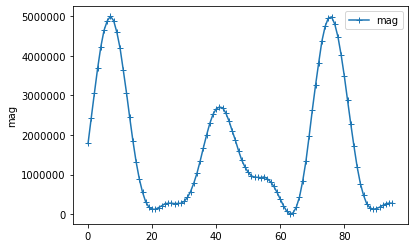

In [9]:
# parsing for ADC
up0, lw0 = np.int16(wide_data[0::4] >> 16), np.int16(wide_data[0::4] & 0x0000ffff)
up1, lw1 = np.int16(wide_data[1::4] >> 16), np.int16(wide_data[1::4] & 0x0000ffff)
I3 = np.zeros(4096)
Q3 = np.zeros(4096)
Q3[0::2] = lw0
Q3[1::2] = up0
I3[0::2] = lw1
I3[1::2] = up1
plt.figure(figsize=(13,7))
c = slice(4000,4096)

plt.subplot(221)
plt.plot(I3[c],"-+",label="I")
plt.plot(Q3[c],"-+",label="Q")
#print(np.max(I3[c]))
plt.ylabel("ADU")
plt.legend()

plt.figure()
plt.plot(I3[c]**2 + Q3[c]**2,"-+",label="mag")
#print(np.max(I3[c]))
plt.ylabel("mag")
plt.legend()

<Figure size 936x504 with 0 Axes>

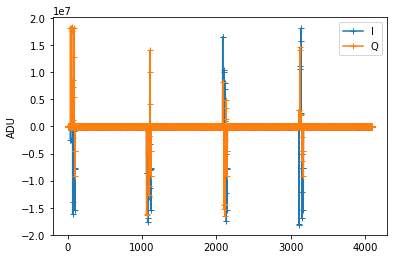

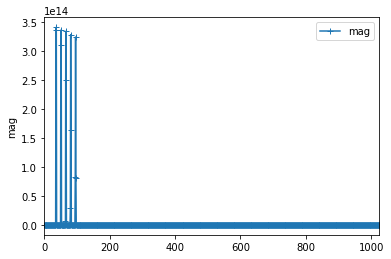

In [12]:
# parsing for PFB
chunk0 = (np.uint64(wide_data[1::4]) << np.uint64(32)) + np.uint64(wide_data[0::4])
chunk1 = (np.uint64(wide_data[2::4]) << np.uint64(32)) + np.uint64(wide_data[1::4])
q0 = np.int64((chunk0 & 0x000000000003ffff)<<np.uint64(46))/2**32
i0 = np.int64(((chunk0>>18) & 0x000000000003ffff)<<np.uint64(46))/2**32
q1 = np.int64(((chunk1>>4)  & 0x000000000003ffff)<<np.uint64(46))/2**32
i1 = np.int64(((chunk1>>22)  & 0x000000000003ffff)<<np.uint64(46))/2**32

I3 = np.zeros(4096)
Q3 = np.zeros(4096)
Q3[0::2] = q0
Q3[1::2] = q1
I3[0::2] = i0
I3[1::2] = i1
plt.figure(figsize=(13,7))
c = slice(0,4096)

plt.figure()
plt.plot(I3[c],"-+",label="I")
plt.plot(Q3[c],"-+",label="Q")
#print(np.max(I3[c]))
plt.ylabel("ADU")
plt.legend()

plt.figure()
plt.plot(I3[c]**2 + Q3[c]**2,"-+",label="mag")
#print(np.max(I3[c]))
plt.xlim(0,1024)
plt.ylabel("mag")
plt.legend()

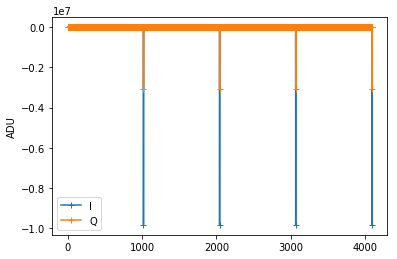

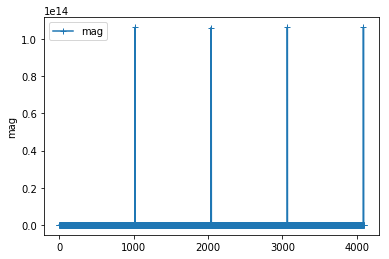

In [51]:
# parsing for DDC
chunk0 = (np.uint64(wide_data[1::4]) << np.uint64(32)) + np.uint64(wide_data[0::4])
chunk1 = (np.uint64(wide_data[2::4]) << np.uint64(32)) + np.uint64(wide_data[1::4])
q0 = np.int64((chunk0 & 0x00000000000fffff)<<np.uint64(45))/2**32
i0 = np.int64(((chunk0>>19) & 0x00000000000fffff)<<np.uint64(45))/2**32
q1 = np.int64(((chunk1>>6)  & 0x00000000000fffff)<<np.uint64(45))/2**32
i1 = np.int64(((chunk1>>25)  & 0x00000000000fffff)<<np.uint64(45))/2**32

I3 = np.zeros(4096)
Q3 = np.zeros(4096)
Q3[0::2] = q0
Q3[1::2] = q1
I3[0::2] = i0
I3[1::2] = i1
plt.figure(figsize=(13,7))
c = slice(0,4096)

plt.figure()
plt.plot(I3[c],"-+",label="I")
plt.plot(Q3[c],"-+",label="Q")
#print(np.max(I3[c]))
plt.ylabel("ADU")
plt.legend()

plt.figure()
plt.plot(I3[c]**2 + Q3[c]**2,"-+",label="mag")
#print(np.max(I3[c]))
plt.ylabel("mag")
plt.legend()

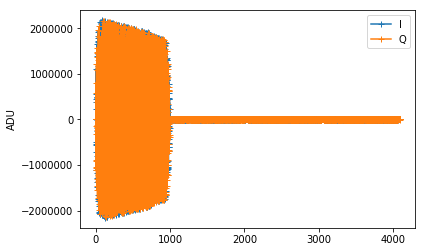

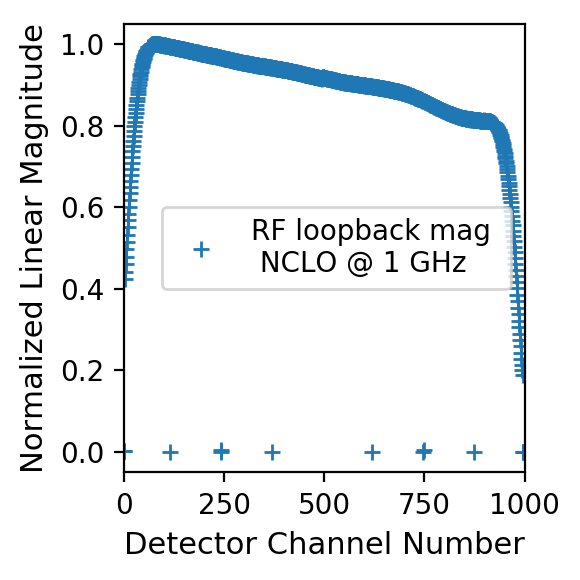

In [12]:
# parsing for ACCUM
q0 = (np.int32(wide_data[1::4])).astype("float")
i0 = (np.int32(wide_data[0::4])).astype("float")
q1 = (np.int32(wide_data[3::4])).astype("float")
i1 = (np.int32(wide_data[2::4])).astype("float")

I3 = np.zeros(4096)
Q3 = np.zeros(4096)
Q3[0::2] = q0
Q3[1::2] = q1
I3[0::2] = i0
I3[1::2] = i1
plt.figure(figsize=(13,7))
c = slice(0,4096)

plt.figure()
plt.plot(I3[c],"-+",label="I")
plt.plot(Q3[c],"-+",label="Q")
#print(np.max(I3[c]))
plt.ylabel("ADU")
plt.legend()

plt.figure(figsize=(3,3),dpi=200)
plt.plot(np.sqrt(I3[c]**2 + Q3[c]**2)/np.max(np.sqrt(I3[c]**2 + Q3[c]**2)),"+",label="RF loopback mag \n NCLO @ 1 GHz")
#print(np.max(I3[c]))
plt.xlim(0,1000)
plt.xlabel("Detector Channel Number", size=11)
plt.ylabel("Normalized Linear Magnitude",size=11)
plt.legend()
plt.tight_layout()
#plt.savefig("normalized_accum_mags_nclo1GHz.png",dpi=250)

In [84]:
def _loop_test():

    # np.diff(freqs/2)[:2]

    f_center =  1e3 # MHz
    N_steps =  500 # 
    tone_diff = np.diff(freqs)[0]/1e6 # MHz
    flo_step = tone_diff/N_steps
    flo_start = f_center - tone_diff/2. #256
    flo_stop =  f_center + tone_diff/2. #256
    
    flos = np.arange(flo_start, flo_stop, flo_step)

    rf_data_conv = firmware.usp_rf_data_converter_0

    def temp(lofreq):
        rf_data_conv.adc_tiles[0].blocks[0].MixerSettings['Freq']=lofreq
        rf_data_conv.dac_tiles[1].blocks[3].MixerSettings['Freq']=lofreq
        rf_data_conv.adc_tiles[0].blocks[0].UpdateEvent(xrfdc.EVENT_MIXER)
        rf_data_conv.dac_tiles[1].blocks[3].UpdateEvent(xrfdc.EVENT_MIXER)
        # Read values and trash initial read, suspecting linear delay is cause..
        I, Q = get_snap_data(3)
        I, Q = get_snap_data(3)

        IQ_mags = np.sqrt(I**2 + Q**2)[0:len(freqs)]

        print(".", end="")

        return IQ_mags

    sweep_mags = np.array([
        temp(lofreq)
        for lofreq in flos
    ])

    print(sweep_mags.shape)

    f = np.array([flos + ftone for ftone in freqs]).flatten()
    sweep_mags_f = sweep_mags.flatten()

    return (f,sweep_mags_f)

f, sweep_mags_f = _loop_test()

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................(500, 1000)


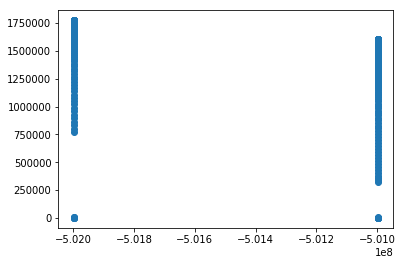

In [89]:
plt.scatter(f[0:1000],sweep_mags_f[0:1000])

(0, 1023)

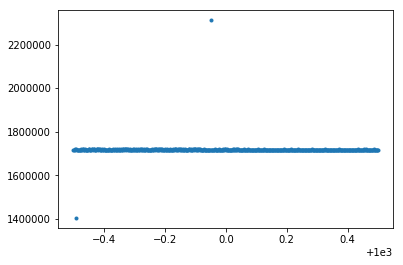

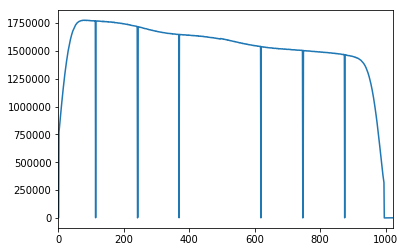

In [63]:
plt.plot(flos,sweep_mag.T[50],".")
plt.figure()
plt.plot(sweep_mag[0])
plt.xlim(0,1023)

(0, 1023)

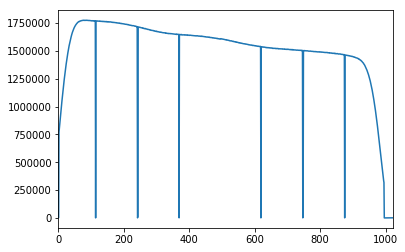

In [49]:
I,Q = get_snap_data(3)
plt.figure()
plt.plot(np.sqrt(I**2 + Q**2))
plt.xlim(0,1023)

In [ ]:
# [ftone + flos for ftone in freqs]

# print(flos)

f = []
sweep_mags_f = []
for n,ftone in enumerate(freqs/2):
    f.append(ftone + flos)
    print(n)
#     sweep_mags_f.append(sweep_mags[n])



In [ ]:
# DDS shift debug loop
dds_shift=firmware.gpio3.axi_gpio_0 # DDS SHIFT offset = 0x00, 0x08 is open
for step in range(512):
    dds_shift.write(0x00,step) # WRITING TO DDS SHIFT 
    sleep(.01)
    ddc_IQ_dat = get_ddc_data(ddc_snap).astype("int32")
    Iddc_f = ddc_IQ_dat[0::2].astype("float")/2**13
    Qddc_f = ddc_IQ_dat[1::2].astype("float")/2**13
    IQddc=abs(Iddc_f+1j*Qddc_f)
    peak=IQddc[np.argmax(IQddc[:1024])]
    print(step, peak)